### We will be using FiftyOne, an open-source ML developer tool that will let you easily manipulate and visualize image datasets as well as generate embedding on your data using its model zoo.

In [1]:
#pip install fiftyone

### We will use the CIFAR-100 dataset, which contains 60,000 images with over 4500 duplicate images between the train and test split annotated with 100 label classes grouped into 20 “super classes”. This dataset also exists in the FiftyOne Dataset Zoo and can be easily loaded. 

# Load Dataset

In [2]:
#for now, we load a subset of the dataset containing 500 samples from each split
import fiftyone.zoo as foz
data= foz.load_zoo_dataset("cifar100", shuffle= True, max_samples= 1000)

Split 'train' already downloaded


INFO:fiftyone.zoo.datasets:Split 'train' already downloaded


Split 'test' already downloaded


INFO:fiftyone.zoo.datasets:Split 'test' already downloaded


Loading 'cifar100' split 'train'


INFO:fiftyone.zoo.datasets:Loading 'cifar100' split 'train'


 100% |███████████████| 1000/1000 [1.7s elapsed, 0s remaining, 627.2 samples/s]         


INFO:eta.core.utils: 100% |███████████████| 1000/1000 [1.7s elapsed, 0s remaining, 627.2 samples/s]         


Loading 'cifar100' split 'test'


INFO:fiftyone.zoo.datasets:Loading 'cifar100' split 'test'


 100% |███████████████| 1000/1000 [1.3s elapsed, 0s remaining, 778.2 samples/s]         


INFO:eta.core.utils: 100% |███████████████| 1000/1000 [1.3s elapsed, 0s remaining, 778.2 samples/s]         


Dataset 'cifar100-1000' created


INFO:fiftyone.zoo.datasets:Dataset 'cifar100-1000' created


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


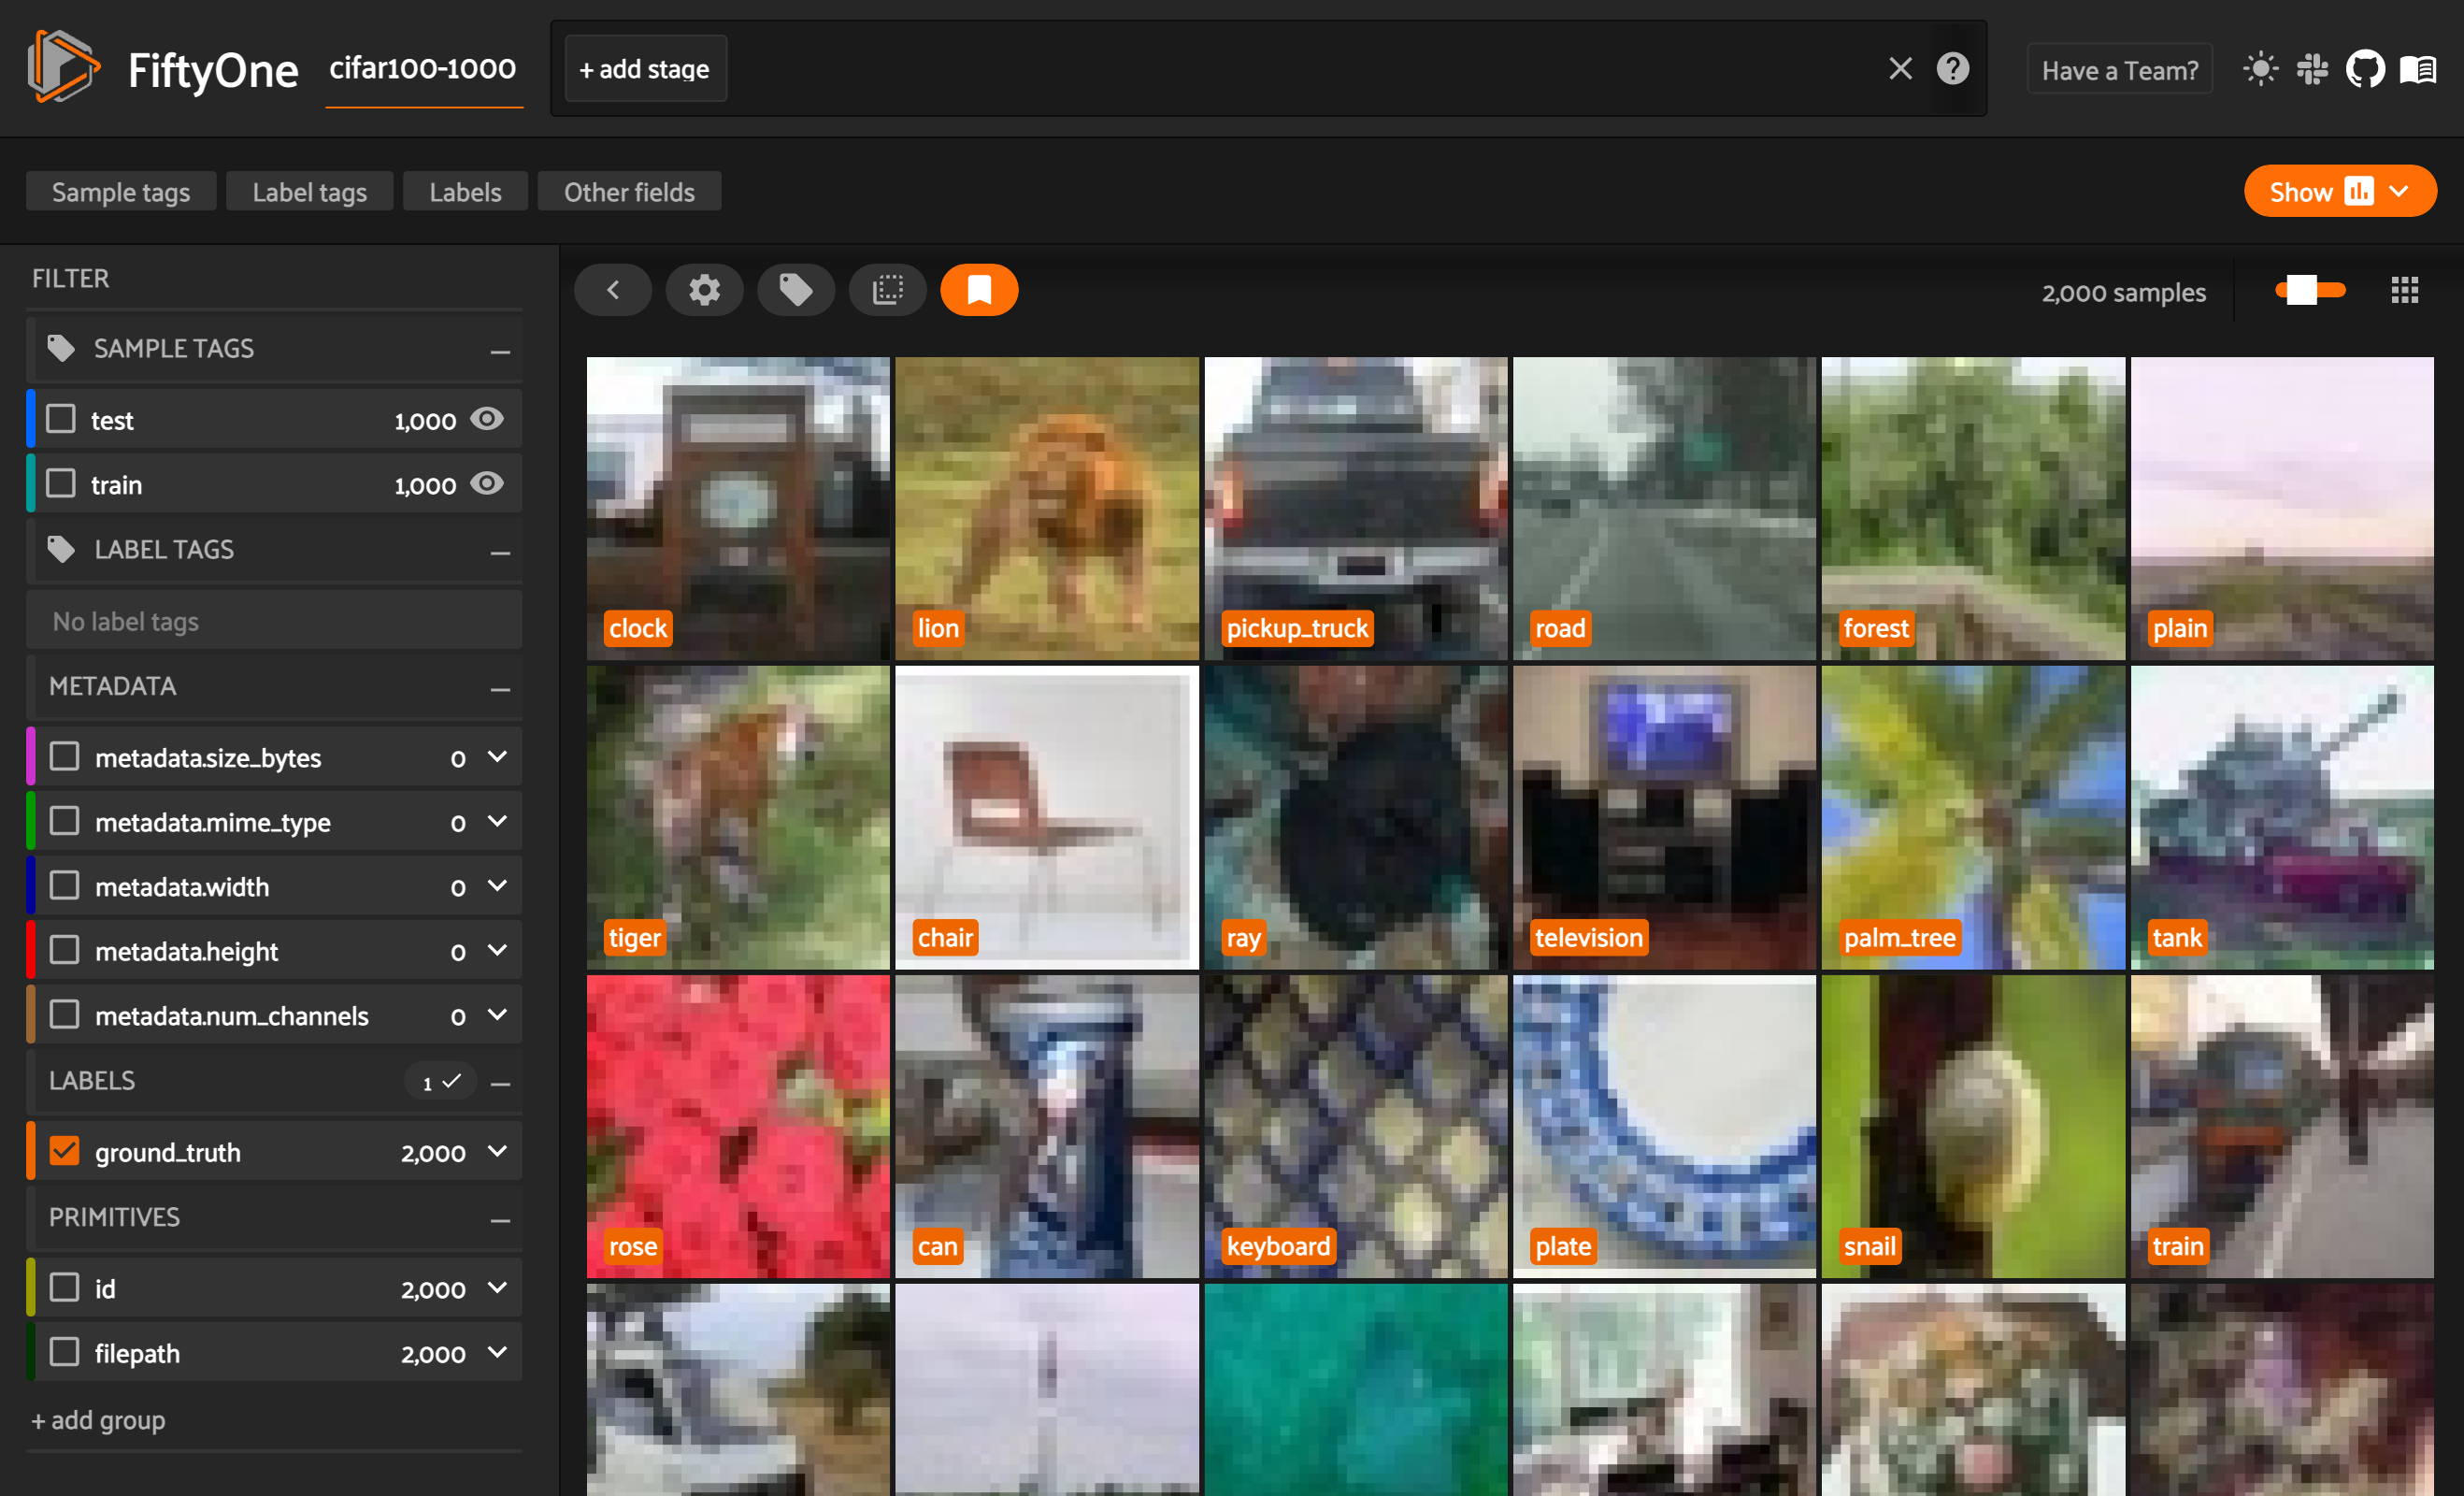

<IPython.core.display.Javascript object>

In [3]:
import fiftyone as fo
session= fo.launch_app(data)

# Generate Embeddings
Now we generate embeddings for the images. Image embeddings are a way of representing images as numerical vectors in a lower-dimensional space. They capture the visual content of an image and can be used to compare the similarity of different images. 

The FiftyOne Model Zoo contains many pretrained models that we can use. For now, we use MobileNet as this model provides relatively high performance, is lightweight and can process our dataset quicker than other models. 

In [4]:
model= foz.load_zoo_model("mobilenet-v2-imagenet-torch")
embeddings= data.compute_embeddings(model)

print(embeddings.shape)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


 100% |███████████████| 2000/2000 [1.8m elapsed, 0s remaining, 18.1 samples/s]      


INFO:eta.core.utils: 100% |███████████████| 2000/2000 [1.8m elapsed, 0s remaining, 18.1 samples/s]      


(2000, 1280)


# Calculate Similarity
Now that we have significantly reduced the dimensionality of our images, we can use classical similarity algorithms like cosine similarity to compute how similar every image embedding is to every other image embedding.

In [5]:
from sklearn.metrics.pairwise import cosine_similarity
similarity_matrix = cosine_similarity(embeddings)

print(similarity_matrix.shape)

# The N x N similarity matrix provides a value between 0 (low similarity) and 1 (identical) for each pair of your N samples

(2000, 2000)


All diagonal values are 1 since every image is identical to itself. We can subtract by the identity matrix (N x N matrix with 1’s on the diagonal and 0’s elsewhere) in order to zero out the diagonal so those values don’t show up when we look for samples with maximum similarity

In [6]:
import numpy as np

n=len(similarity_matrix)
similarity_matrix= similarity_matrix- np.identity(n)

# Visualize and Remove Duplicates
We can now iterate through every sample and find which other samples are the most similar to it.

In [7]:
id_map = [s.id for s in data.select_fields(["id"])]
#creates a list called id_map that contains the id field for each element in the dataset.
#The id_map list will contain the id field for each element in the dataset. For example, if the dataset object contains 10 elements, the id_map list will contain 10 elements, one for each element in the dataset
for idx, sample in enumerate(data):
  max_similarity= similarity_matrix[idx].max()
  sample["max_similarity"]= max_similarity
  sample.save()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


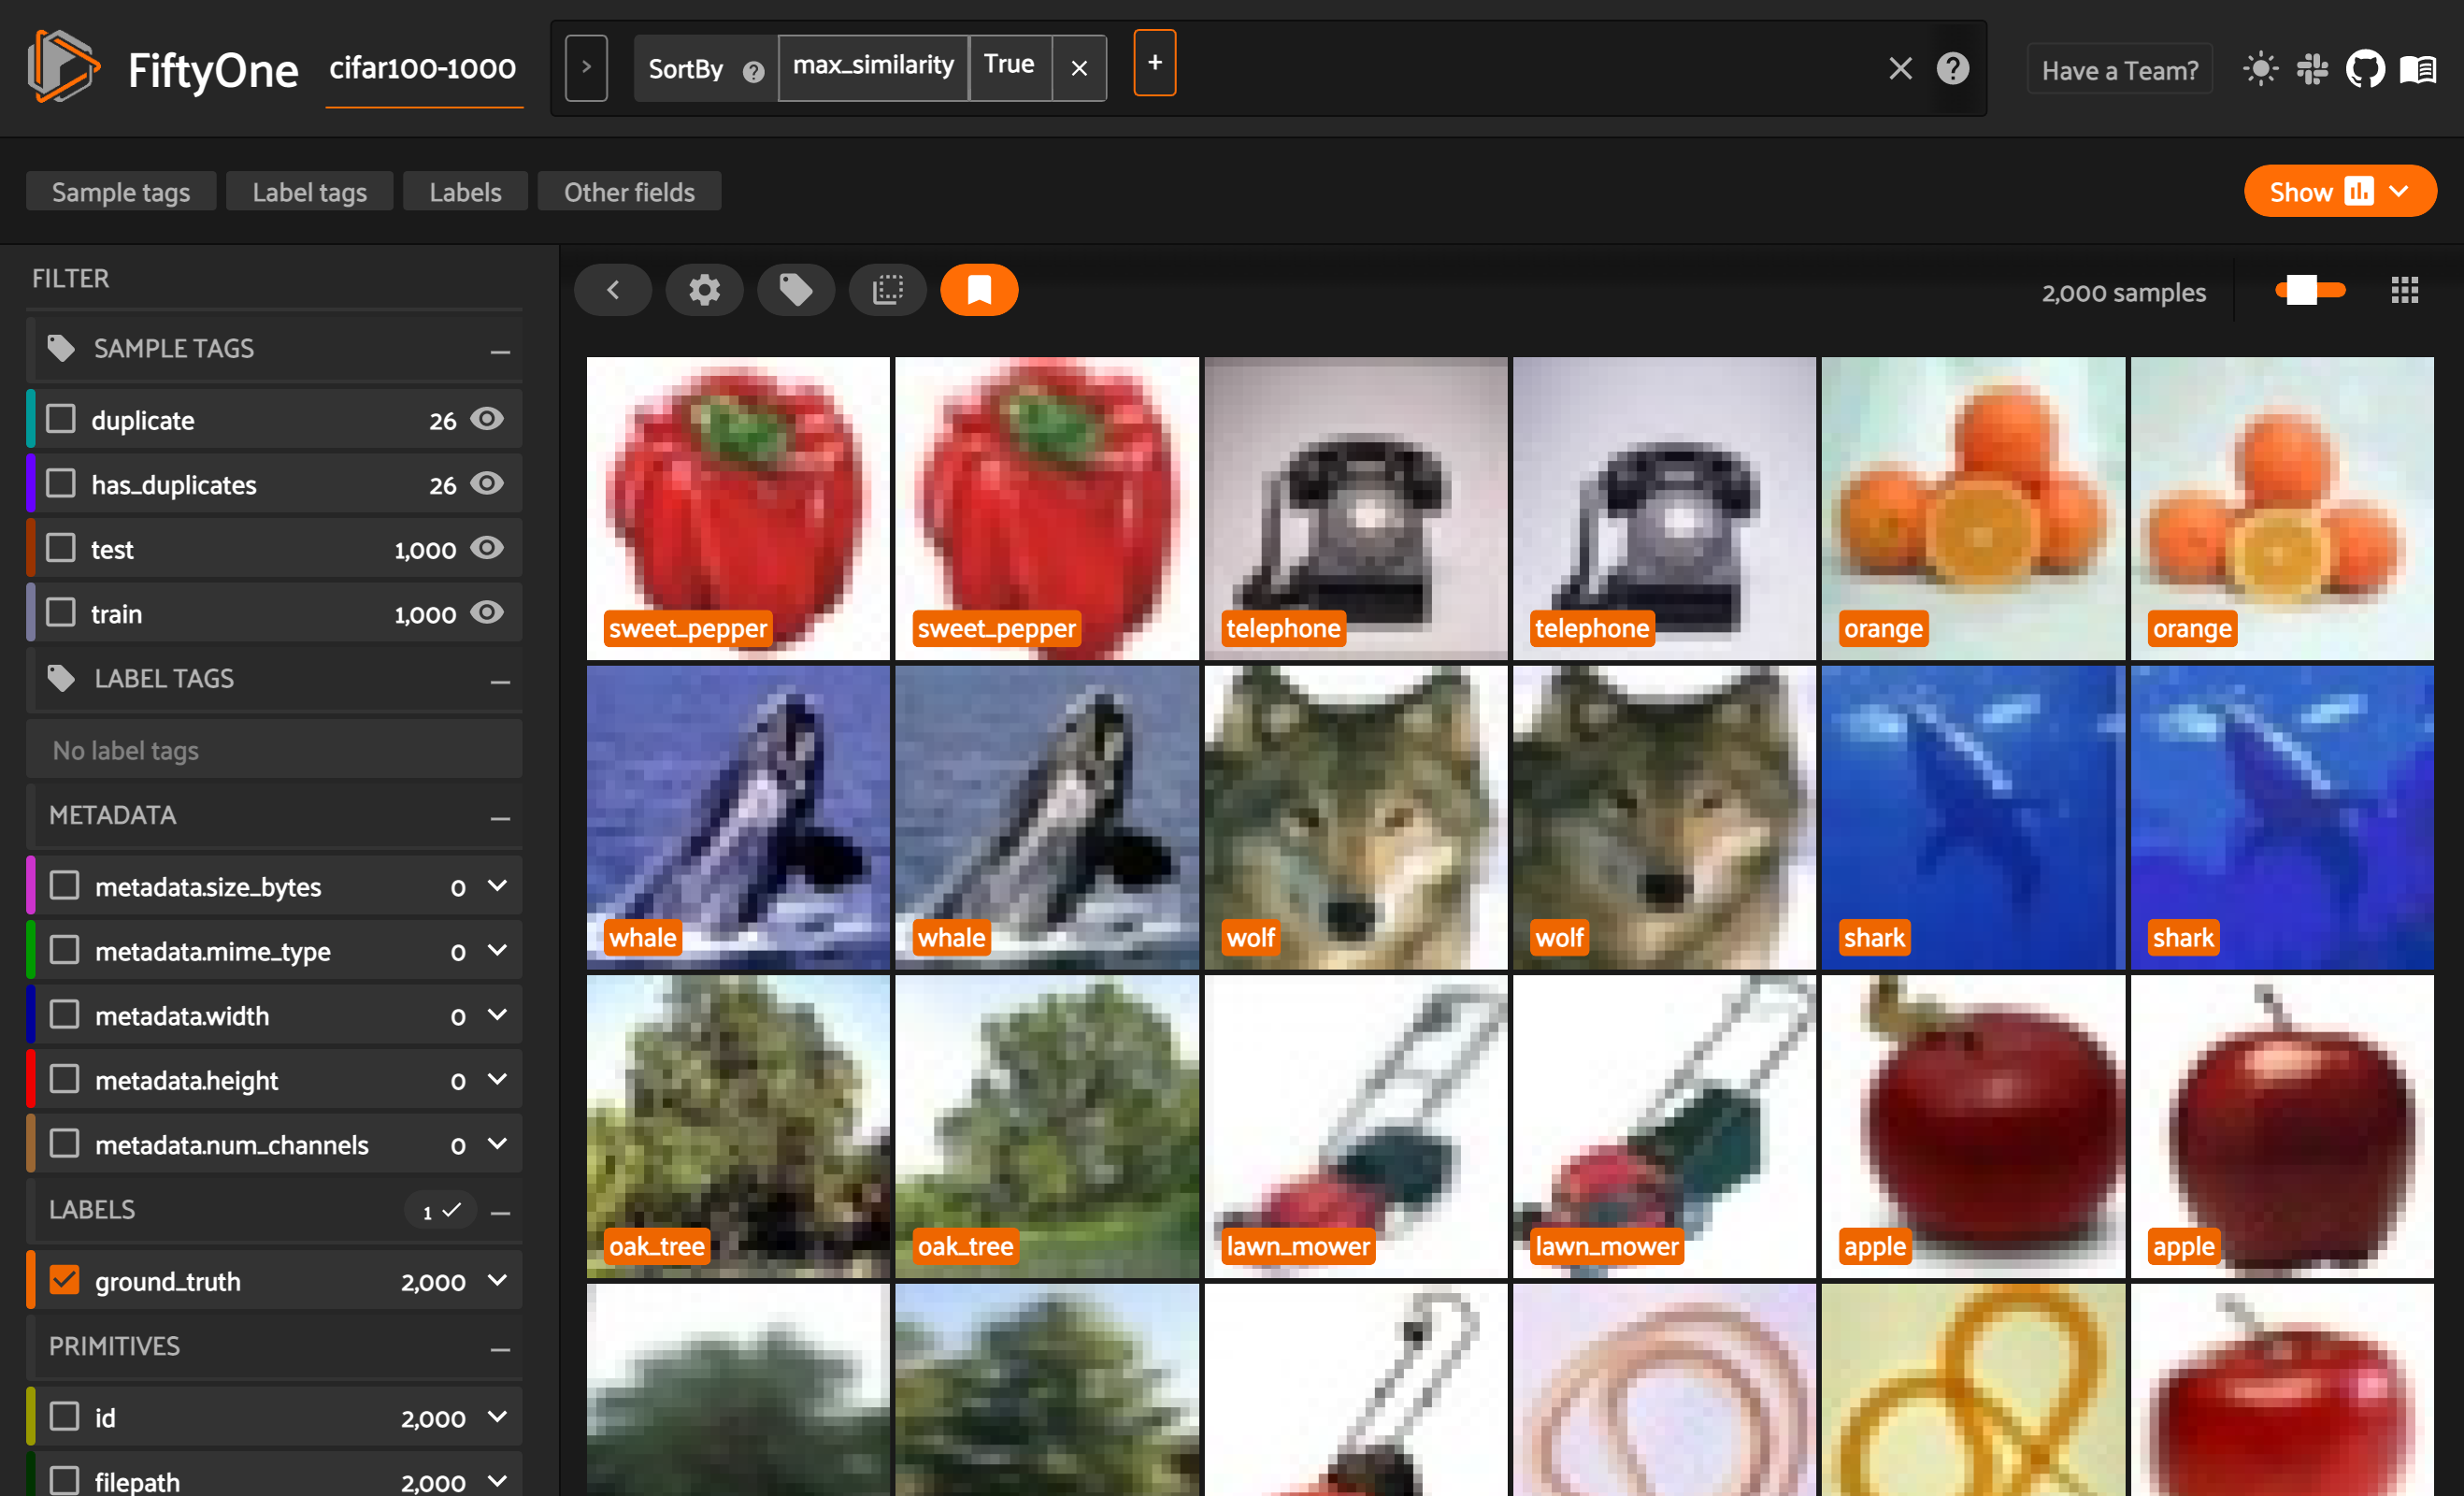

<IPython.core.display.Javascript object>

In [8]:
session.show()

We use the range slider in the FiftyOne App for an easy way to reduce the max_similarity score until we stop seeing duplicates.
We find that a good threshold for guaranteed duplicates is around 0.89. Lower values also include duplicates but should be verified manually so that we do not remove useful data. 
We can filter the dataset through code as well to see just how many samples have a max_similarity of > 0.89.



In [12]:
from fiftyone import ViewField as F

data.match(F("max_similarity")>0.89)

Dataset:     cifar100-1000
Media type:  image
Num samples: 52
Sample fields:
    id:             fiftyone.core.fields.ObjectIdField
    filepath:       fiftyone.core.fields.StringField
    tags:           fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:       fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    ground_truth:   fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)
    max_similarity: fiftyone.core.fields.FloatField
View stages:
    1. Match(filter={'$expr': {'$gt': [...]}})

we see 52 samples are marked duplicates
We can now iterate through our dataset again and find all duplicates of > 0.89 similarity for each sample, either tagging them as “duplicate” or removing them.

In [10]:
thresh = 0.89
samples_to_remove = set()
samples_to_keep = set()

for idx, sample in enumerate(data):
    if sample.id not in samples_to_remove:
        # Keep the first instance of two duplicates
        samples_to_keep.add(sample.id)
        
        dup_idxs = np.where(similarity_matrix[idx] > thresh)[0]
        for dup in dup_idxs:
            # We kept the first instance so remove all other duplicates
            samples_to_remove.add(id_map[dup])

        if len(dup_idxs) > 0:
            sample.tags.append("has_duplicates")
            sample.save()

    else:
        sample.tags.append("duplicate")
        sample.save()

print(len(samples_to_remove) + len(samples_to_keep))


2000


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


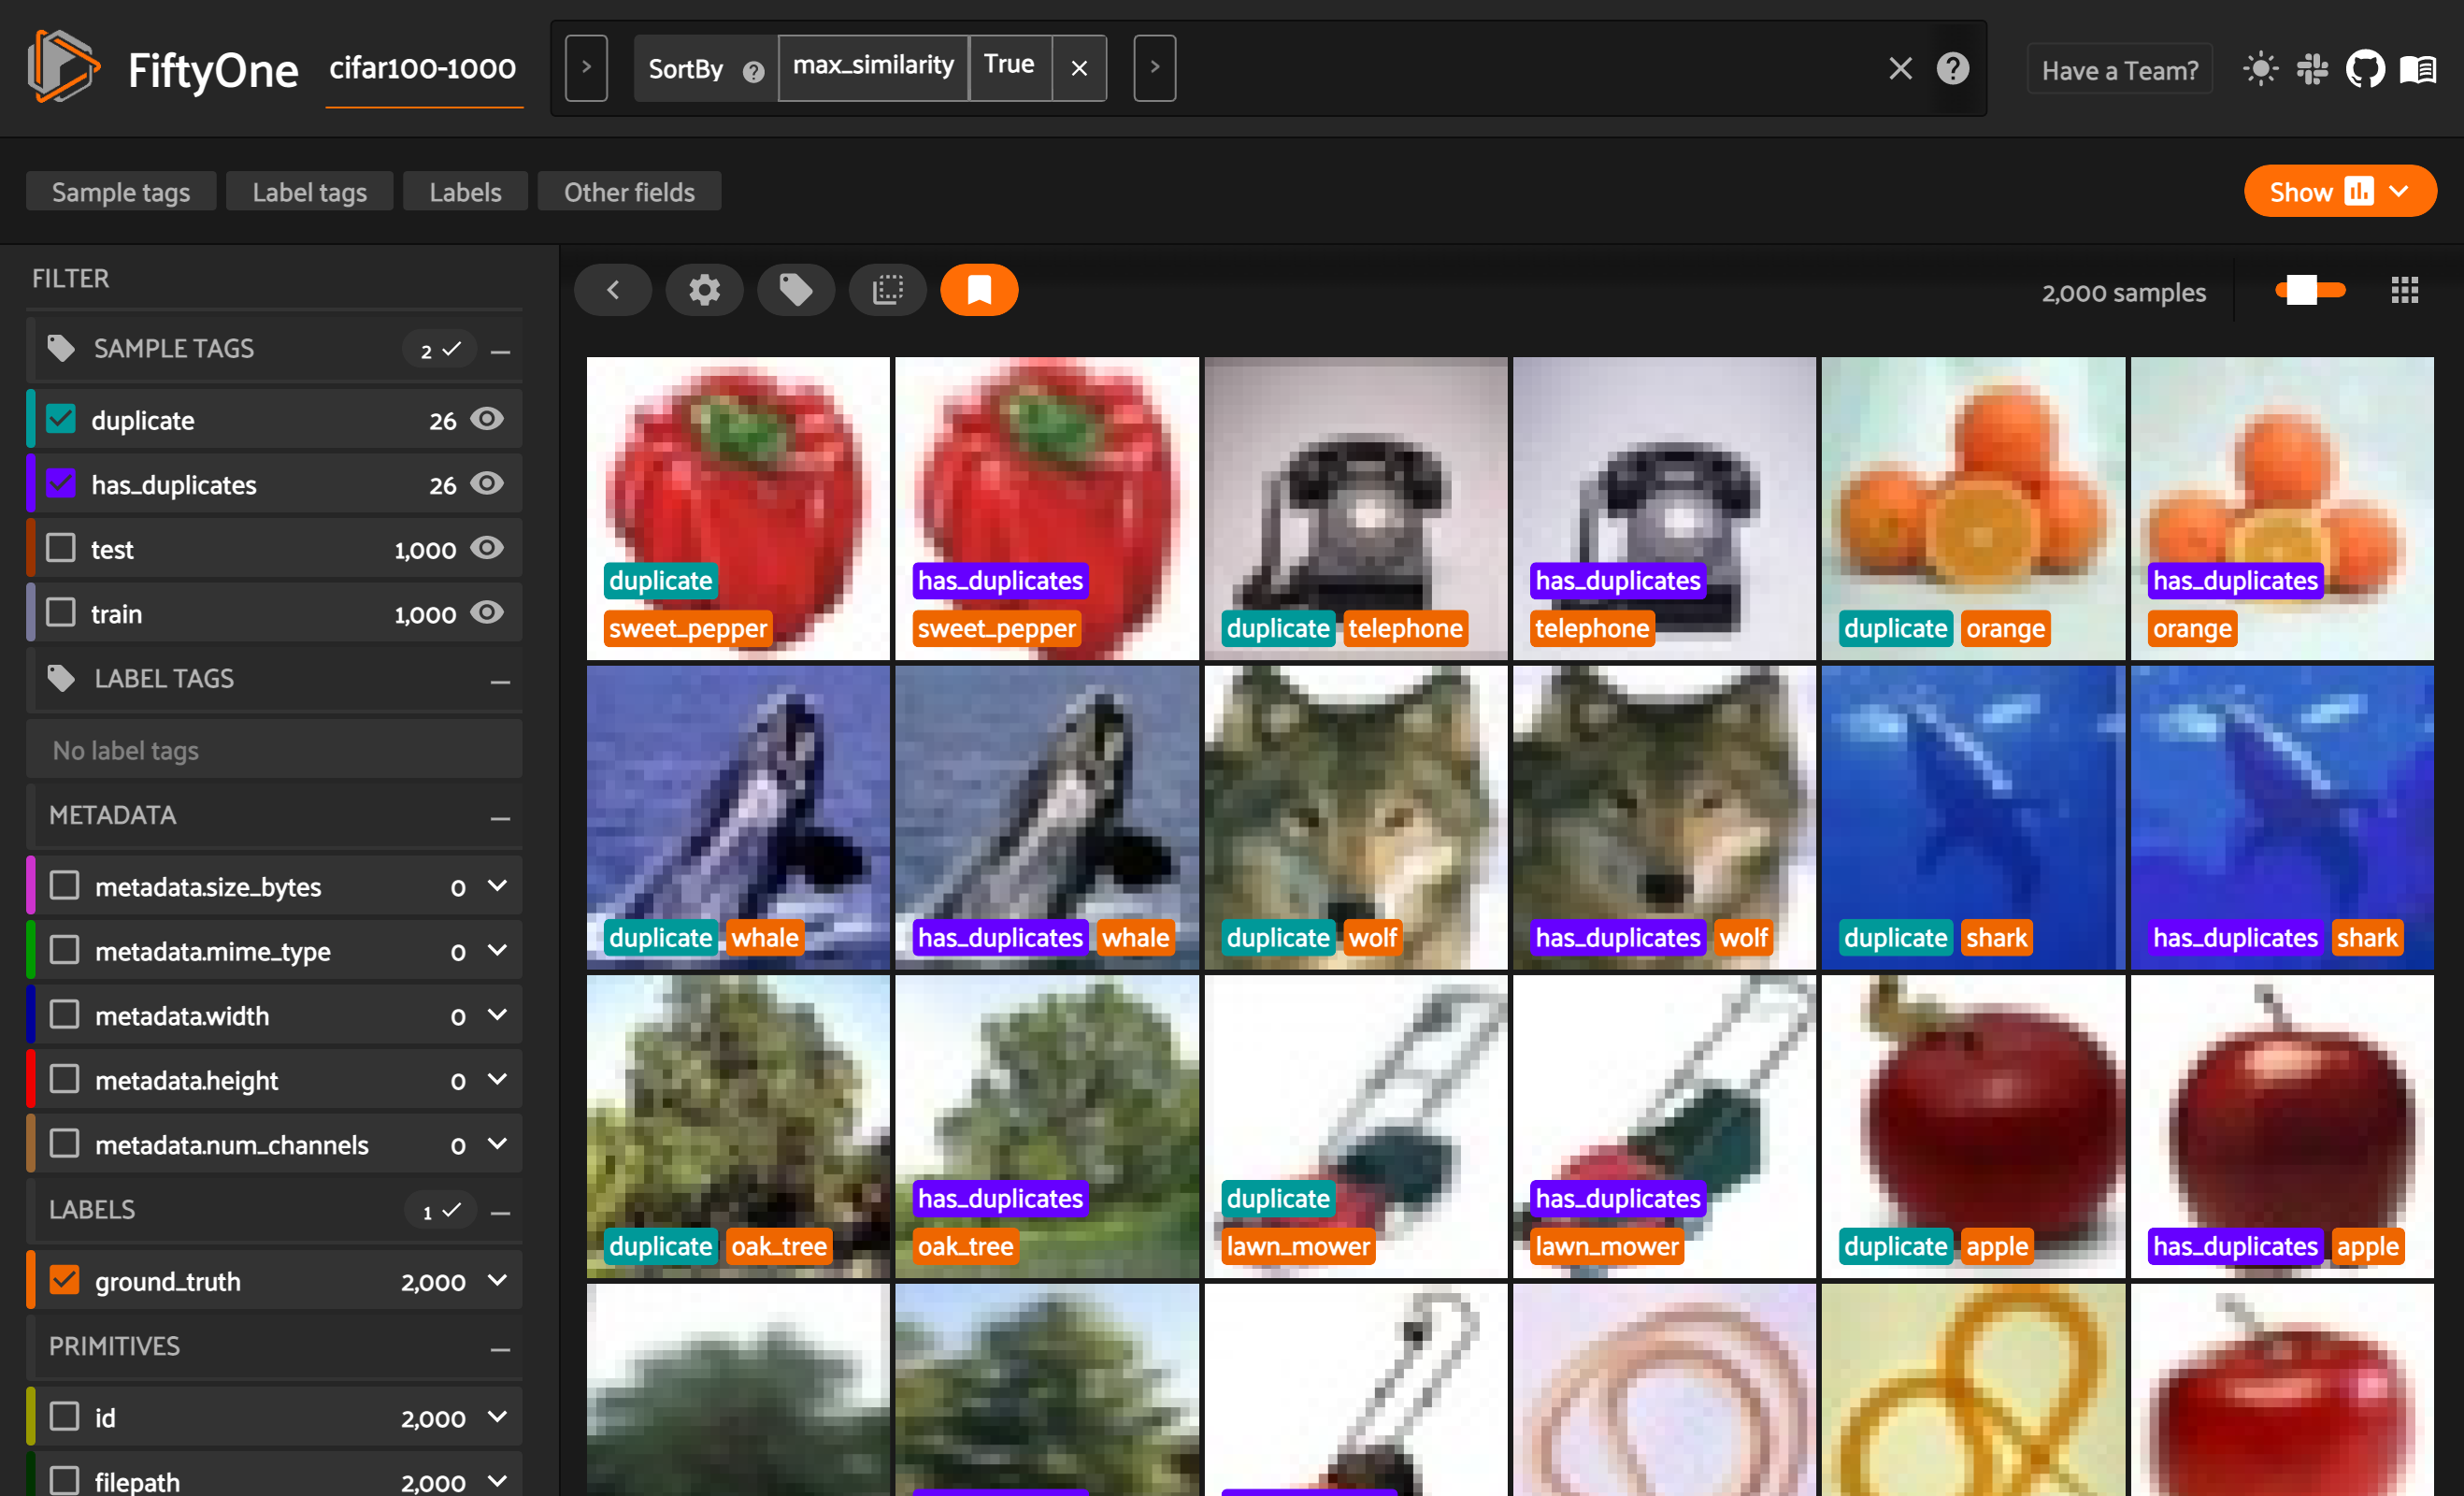

<IPython.core.display.Javascript object>

In [11]:
session.show()

In [16]:
data.delete_samples(list(samples_to_remove))

In [17]:
session.show()

In this way, we can remove all duplicate images from a dataset